In [11]:
import warnings
warnings.filterwarnings('ignore')
from pandas import DatetimeIndex
from pandas import Timestamp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time
from sklearn import svm
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import max_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_tweedie_deviance
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import plotly.offline as py 
import plotly.graph_objects as go
import plotly.express as px
pd.set_option('display.float_format', lambda x: '%.6f' % x)
#import wget

In [12]:
#read in data
covid = pd.read_csv('United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
covid['submission_date'] = pd.to_datetime(covid['submission_date'])
covid = covid.sort_values(by = 'submission_date')
#covid

In [13]:
#set state as NC
state_data=covid[covid["state"]=="NC"]
#state_data=covid[covid["state"]=="CA"]
#state_data=covid[covid["state"]=="FL"]
#set start date
start_date = '2020-12-14'
end_date = '2021-11-19'
mask = (state_data['submission_date'] >= start_date) & (state_data['submission_date'] <= end_date)
state_data = state_data.loc[mask]
#set date as datetime object
datewise_state=state_data.groupby(["submission_date"]).agg({"tot_cases":'sum'})
datewise_state

,tot_cases
submission_date,
2020-12-14,456859
2020-12-15,465873
2020-12-16,473753
2020-12-17,480267
2020-12-18,487765
...,...
2021-10-28,1475148
2021-10-29,1477514
2021-10-30,1477514


In [14]:
datewise_state["Days Since"]=datewise_state.index-datewise_state.index[0]
datewise_state["Days Since"]=datewise_state["Days Since"].dt.days
#covid["Days Since"]=covid.index-covid.index[0]
#covid["Days Since"]=covid["Days Since"].dt.days
train_ml= datewise_state.iloc[:int(datewise_state.shape[0]*0.85)]
#test_ml = datewise_state.iloc[:int(datewise_state.shape[0]*0.20)]
valid_ml=datewise_state.iloc[int(datewise_state.shape[0]*0.85):]
#valid_ml
#test_ml

In [15]:
#function for plot result on forecast cases
def plot_result(data_d,new_date_time_index, forecast, gcolor, gcase, gtitle):
    plt.style.use('seaborn-white')
    plt.plot(data_d,label="Actual "+gcase,color=gcolor, linestyle='solid', linewidth = 3, marker='o', markerfacecolor=gcolor, markersize=12)
    plt.plot(new_date_time_index,forecast,label="Predicted "+gcase,color='black', linestyle='solid', linewidth = 3, marker='*', markerfacecolor='black', markersize=12)
    #plt.xlabel('Date Time')
    #plt.ylabel(gcase)
    #plt.title(gtitle)

In [16]:
#function for prediction on new cases
def new_forecast(prediction,new_prediction,new_date):
    forecast=np.concatenate((prediction,new_prediction))
    new_ar = []
    for single_timestamp in datewise_state.index:
        new_ar.append(pd.to_datetime(single_timestamp))

    for single_timestamp in new_date:
        new_ar.append(pd.to_datetime(single_timestamp))

    new_date_time_index = DatetimeIndex(new_ar, dtype='datetime64[ns]', name='Date', freq=None)

    return (forecast,new_date_time_index)

In [17]:
#function to output MAE and R2 values of out model
def e_cal(y,y_p):
    print("Mean Absolute Error: ",mean_absolute_error(y,y_p))
    print("R2-Squared:", r2_score(y,y_p))

In [24]:
#function to display an interactive graph for confirmed cases vs. predictied cases from our model
def  interactive_graph (index_d,forecast_d):   
     
     #fig = px.line(datewise_bd, x=index_c, y=forecast_c)
     #fig.add_scatter(x=index_c, y=datewise_state['Confirmed']) 
     #fig1 = plt.axes()
     fig1 = px.line(datewise_state, x=index_d, y=forecast_d )
     fig1.add_scatter(x=index_d, y=datewise_state['tot_cases'])
     fig1.update_traces(showlegend=True)
     #fig1.legend(('Pop1', 'Pop2'), 'upper right')
     fig1.update_layout(
     title="Trend of total cases of COVID-19 in North Carolina",
     xaxis_title="Time start from 2020-12-14 ",
     yaxis_title="Total number of COVID-19 cases ",
     legend_title="Purple(Predicted), Red(Actual)",
     #fig1.legend(('Pop1', 'Pop2'), 'upper right'), 
     font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )        
)
     fig1.show()

In [19]:
#multi layer perceptron model 
def MLPRegression_covid_19(train_d,valid_d,data_d,case):
    #declare model score as empty list object
    model_scores=[]
    #Maximum number of iterations. 
    #iterates until convergence.     
    mlp=MLPRegressor(hidden_layer_sizes=[20,10,5], max_iter=50000, alpha=0.0005, random_state=26)  
    #fit mlp
    mlp.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_d).reshape(-1,1))
    print(case)
    #apply prediction cases using the mlp
    prediction_valid_mlp=mlp.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
    #print("Valid: ",prediction_valid_mlp)
    #store model scores into the list object declared above
    model_scores.append(np.sqrt(mean_squared_error(valid_d,prediction_valid_mlp)))
    #show RMSE
    print("RMSE for MLP: ",model_scores)
    #calculate MAE and R2 of input valid_d and prediction_valid_mlp
    e_cal(valid_d,prediction_valid_mlp)
    #get final prediction as numpy array
    prediction_mlp=mlp.predict(np.array(datewise_state["Days Since"]).reshape(-1,1))
    
    new_date=[]
    new_prediction_mlp=[]
    
    #iterate through range(day) to store date values and prediction values
    day=8
    for i in range(1,day):
        new_date.append(datewise_state.index[-1]+timedelta(days=i))
        new_prediction_mlp.append(mlp.predict(np.array(datewise_state["Days Since"].max()+i).reshape(-1,1))[0]) 
    forecast_mlp, new_date_time_index =new_forecast(prediction_mlp,new_prediction_mlp,new_date)
    #plot_result(data_d,new_date_time_index, forecast_mlp,'blue', case, 'Multi Layer Perception Prediction')

    return (forecast_mlp, new_date_time_index, model_scores)

Total Cases
RMSE for MLP:  [43941.10886647879]
Mean Absolute Error:  41158.87526017447
R2-Squared: 0.09562495433920826


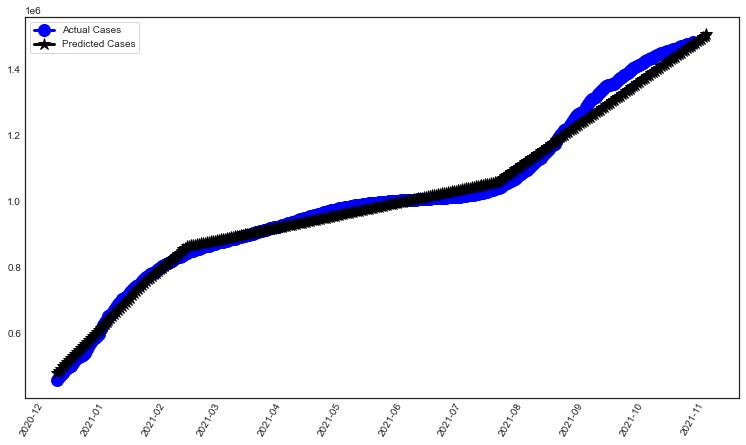

Execution Time 54.017661


In [20]:
t = time.process_time()
forecast_mlp_d, new_date_time_index_d, model_score_mlp_d = MLPRegression_covid_19(train_ml["tot_cases"],valid_ml["tot_cases"],datewise_state["tot_cases"],'Total Cases')
plt.figure(figsize=(12.8,7))
plot_result(datewise_state["tot_cases"],new_date_time_index_d, forecast_mlp_d,'blue','Cases', 'MLP Regression')
plt.xticks(rotation=60)
plt.legend(frameon=True)
plt.show() 
elapsed_time_mlp = time.process_time() - t
print("Execution Time", elapsed_time_mlp)

In [25]:
interactive_graph(new_date_time_index_d,forecast_mlp_d)